In [60]:
import csv
import numpy as np
from collections import deque
import copy
import random
import time
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

# ================== CONFIG / SWITCH ==================
print("=== Sélection de l'instance ===")
print("1 - 6X6.csv")
print("2 - 11X11.csv")
print("3 - 51X51.csv")
print("4 - 101X101.csv")
print("5 - 201X201.csv")
print("6 - 501X501.csv")
print("7 - 1001X1001.csv")
print("8 - 1501X1501.csv")
print("9 - 2001X2001.csv")
choix = input("Choisissez la matrice à utiliser (1-9) : ")

if choix == "1":
    csv_path = "instance/6X6.csv"
    nameFile = "6X6.csv"
elif choix == "2":
    csv_path = "instance/11X11.csv"
    nameFile = "11X11.csv"
elif choix == "3":
    csv_path = "instance/51X51.csv"
    nameFile = "51X51.csv"
elif choix == "4":
    csv_path = "instance/101X101.csv"
    nameFile = "101X101.csv"
elif choix == "5":
    csv_path = "instance/201X201.csv"
    nameFile = "201X201.csv"
elif choix == "6":
    csv_path = "instance/501X501.csv"
    nameFile = "501X501.csv"
elif choix == "7":
    csv_path = "instance/1001X1001.csv"
    nameFile = "1001X1001.csv"
elif choix == "8":
    csv_path = "instance/1501X1501.csv"
    nameFile = "1501X1501.csv"
elif choix == "9":
    csv_path = "instance/2001X2001.csv"
    nameFile = "2001X2001.csv"
else:
    csv_path = "instance/6X6.csv"
    nameFile = "6X6.csv"

try:
    nbTrucks = int(input("Nombre de camions à utiliser : "))
except:
    nbTrucks = 10  # valeur par défaut

# Parameters
depot = 0
MAX_CYCLE_TIME = 720  # durée maximale d’un cycle de camion (unité cohérente avec tes matrices)
# seuils fixes demandés
SEUIL1 = 240
SEUIL2 = 480

# === Utilitaires de lecture (définit avant usage) ===
def lire_matrice_csv(filename):
    """Lit une matrice CSV et renvoie une liste de listes (int)."""
    matrice = []
    with open(filename, newline='') as f:
        lecteur = csv.reader(f)
        for ligne in lecteur:
            # ignorer champs vides
            valeurs = [int(float(x)) for x in ligne if x.strip() != ""]
            if valeurs:
                matrice.append(valeurs)
    return matrice

# Ensure 'matrice' output folder exists
if not os.path.exists("matrice"):
    os.makedirs("matrice")

# === Chargement de la matrice de base (celle choisie) ===
try:
    # np.loadtxt -> fallback to lire_matrice_csv if fails
    try:
        base_matrix = np.loadtxt(csv_path, delimiter=",", dtype=int).tolist()
    except Exception:
        base_matrix = lire_matrice_csv(csv_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Fichier introuvable : {csv_path}")

# pour compatibilité, matrix variable (utilisée ailleurs)
matrix = base_matrix

# ================== Fonctions algorithme (inchangées en interface) ==================
def voisinMinPoid(matrix_local, listeClient, cur):
    poidMinTrajet = 0
    nextVoisin = -1
    for i in listeClient:
        if matrix_local[cur][i] > 0 and (poidMinTrajet == 0 or matrix_local[cur][i] < poidMinTrajet):
            nextVoisin = i
            poidMinTrajet = matrix_local[cur][i]
    return nextVoisin, poidMinTrajet

def voisinsClientGraphematrix(matrix_local, sommet):
    return [i for i in range(len(matrix_local)) if matrix_local[sommet][i] > 0]

def poidCycle():
    return sum(truckCycles[0])

# ================== Fonction demandée : recherche_tabou_cycle (avec matrices horaires) ==================
def recherche_tabou_cycle(matrix_base, start):
    """
    Recherche tabou adaptative qui utilise la matrice 8h/12h/16h selon
    le temps cumulé n = truckCycles[0][truckAtMove].
    - si n < SEUIL1 -> matrice 8h
    - elif n < SEUIL2 -> matrice 12h
    - else -> matrice 16h
    Empêche un mouvement qui ferait dépasser MAX_CYCLE_TIME.
    """
    # copie locale pour manipulations (prévention d'écrasement)
    matrix_copy = copy.deepcopy(matrix_base)
    tabou = deque(maxlen=len(matrix_base))
    tabou.append(start)

    # initialise truckCycles si nécessaire (sécurité)
    if 'truckCycles' not in globals():
        raise RuntimeError("truckCycles non initialisé avant appel de recherche_tabou_cycle")

    # assure que chaque camion a au moins le depot dans sa route
    for i in range(nbTrucks):
        if not truckCycles[1][i]:
            truckCycles[1][i] = [start]
        tabou.append(truckCycles[1][i][-1])

    # boucle principale: on s'arrête quand tous les sommets sont tabous/visités
    while len(tabou) < len(matrix_base):
        # choisir camion avec temps minimal (équilibrage)
        truckAtMove = truckCycles[0].index(min(truckCycles[0]))
        cur = truckCycles[1][truckAtMove][-1]

        # temps cumulé du camion
        n = truckCycles[0][truckAtMove]

        # Vérification MAX_CYCLE_TIME
        if n >= MAX_CYCLE_TIME:
            print(f" ERREUR : camion {truckAtMove+1} atteint {n} >= {MAX_CYCLE_TIME}. Arrêt du lancement.")
            return

        # Choisir matrice en fonction de n (SEUILS : 240 / 480)
        if n < SEUIL1:
            heure_actuelle = 8
        elif n < SEUIL2:
            heure_actuelle = 12
        else:
            heure_actuelle = 16

        nom_fichier_bouchon = f"matrice/{os.path.basename(nameFile).replace('.csv','')}_{heure_actuelle}h.csv"
        # affichage de debug pour vérifier la matrice utilisée
        print(f"→ Camion {truckAtMove+1} | temps={n} : utilisation de {nom_fichier_bouchon}")

        # chargement robuste de la matrice horaire ; fallback sur base si absent
        if os.path.exists(nom_fichier_bouchon):
            try:
                matrice_bouchon = lire_matrice_csv(nom_fichier_bouchon)
            except Exception:
                matrice_bouchon = matrix_copy
        else:
            # si fichier non trouvé, on utilise la base (et notifie)
            matrice_bouchon = matrix_copy
            # print(f" Fichier {nom_fichier_bouchon} introuvable — fallback sur matrice de base.")

        # récupérer voisins selon matrice horaire courante
        voisins = voisinsClientGraphematrix(matrice_bouchon, cur)
        candidats = [v for v in voisins if v not in tabou]

        if not candidats:
            # plus de candidats pour ce camion -> on arrête cette itération
            break

        # choisir voisin minimal (sur la matrice horaire courante)
        voisin, temps = voisinMinPoid(matrice_bouchon, candidats, cur)

        # Test si le nouveau temps dépasse MAX_CYCLE_TIME
        nouveau_temps = n + temps
        if nouveau_temps > MAX_CYCLE_TIME:
            print(f" Camion {truckAtMove+1} : mouvement {cur}->{voisin} refusé "
                  f"(nouveau_temps={nouveau_temps} > {MAX_CYCLE_TIME})")
            # retirer ce candidat et essayer un autre candidat si possible
            # on tente d'enlever la paire (cur,voisin) des candidats et réessayer
            remaining = [c for c in candidats if c != voisin]
            autre_trouve = False
            for cand in remaining:
                cand_voisin, cand_temps = voisinMinPoid(matrice_bouchon, [cand], cur)
                cand_nouveau = n + cand_temps
                if cand_nouveau <= MAX_CYCLE_TIME:
                    # on accepte ce candidat
                    voisin, temps = cand_voisin, cand_temps
                    nouveau_temps = cand_nouveau
                    autre_trouve = True
                    break
            if not autre_trouve:
                # aucun candidat admissible -> on arrête l'avancement pour ce camion
                print(f"→ Aucun candidat admissible pour le camion {truckAtMove+1} sans dépasser {MAX_CYCLE_TIME}.")
                break

        # appliquer suppression de l'arête sur la copie
        matrix_copy[cur][voisin] = 0
        matrix_copy[voisin][cur] = 0

        # mettre à jour camion
        truckCycles[1][truckAtMove].append(voisin)
        truckCycles[0][truckAtMove] = nouveau_temps
        tabou.append(voisin)

    # Après la construction, on force le retour au dépôt pour chaque camion si possible
    for i in range(nbTrucks):
        if truckCycles[1][i]:
            last = truckCycles[1][i][-1]
            cout_retour = matrix[last][depot]
            if truckCycles[0][i] + cout_retour > MAX_CYCLE_TIME:
                print(f" Camion {i+1} ne peut pas rentrer (temps {truckCycles[0][i] + cout_retour} > {MAX_CYCLE_TIME}).")
                # on laisse le camion sans retour pour indiquer l'impossibilité
            else:
                truckCycles[1][i].append(depot)
                truckCycles[0][i] += cout_retour

# ================== Recherche tabou multi-start (interface conservée) ==================
def tabou_multi_start(matrix_local, nb_lancements=20):
    tempsMeilleurCycle = float('inf') # Initialisation du meilleur temps à l'infini pour pouvoir le minimiser ensuite
    goodI = -1
    bestTime = None

    # make sure bouchon matrices exist (create them if missing)
    # this will create matrice/<basename>_8h.csv etc.
    try:
        creer_fichiers_avec_bouchons()
    except Exception as e:
        # if creation fails, we continue: recherche_tabou_cycle fera fallback sur matrix_base
        print(f" Création fichiers bouchons échouée ou déjà faite : {e}")

    for i in range(nb_lancements):
        global truckCycles
        truckCycles = [
            [0] * nbTrucks,
            [[] for _ in range(nbTrucks)]
        ]

        # initialisation : choisir un premier voisin différent pour chaque camion
        for j in range(nbTrucks):
            truckCycles[1][j] = [depot]
            attempts = 0
            while True:
                attempts += 1
                if attempts > 1000:
                    raise RuntimeError("Impossible d'initialiser firstNeighbor (trop d'essais).")
                firstNeighbor = random.randint(1, len(matrix_local)-1)
                if not any(firstNeighbor in cycle for cycle in truckCycles[1]):
                    truckCycles[1][j].append(firstNeighbor)
                    truckCycles[0][j] = matrix_local[depot][firstNeighbor]
                    break

        # lancer la recherche tabou qui gère les matrices horaires
        recherche_tabou_cycle(matrix_local, depot)

        total = poidCycle()
        print(f"Lancement {i+1} terminé : Temps du cycle = {total}")

        for k in range(nbTrucks):
            print(f"Premier client du camion {k+1} : {truckCycles[1][k][0]+1}")
            print(f"Cycle du camion {k+1} : ", " -> ".join(str(x+1) for x in truckCycles[1][k]))
            print(f"Temps total du camion {k+1} : {truckCycles[0][k]}")
            print()

        if total < tempsMeilleurCycle:
            tempsMeilleurCycle = total
            goodI = i
            bestTime = [
                truckCycles[0].copy(),
                [cycle.copy() for cycle in truckCycles[1]]
            ]
            print(f"→ Nouveau meilleur cycle sauvegardé ! Lancement {i+1}.\n")

    return tempsMeilleurCycle, goodI, bestTime

# ================== Partie bouchons (création des 3 matrices horaires) ==================
def generer_facteur_bouchon(heure):
    seed_value = hash(f"bouchon_{heure}") % (2**32)
    random.seed(seed_value)
    intensite = 0.5 + 0.5 * math.sin((heure - 8) / 24 * 2 * math.pi)
    facteur = 2.0 * intensite
    if facteur <= 0:
        facteur = 1
    return facteur

def facteurs_variation(matrice, pourcentage):
    n = len(matrice)
    toutes_les_routes = [(i, j) for i in range(n) for j in range(i + 1, n) if matrice[i][j] != 0]
    nb_a_modifier = int(len(toutes_les_routes) * pourcentage)
    if nb_a_modifier <= 0:
        return []
    routes_selectionnees = random.sample(toutes_les_routes, nb_a_modifier)
    for i, j in routes_selectionnees:
        p = random.uniform(-0.3, 0.3)
        nouvelle_valeur = matrice[i][j] * (1 + p)
        matrice[i][j] = matrice[j][i] = max(1, int(round(nouvelle_valeur)))
    return routes_selectionnees

def creer_fichiers_avec_bouchons():
    """
    Crée 3 fichiers matrice/<basename>_8h.csv, _12h.csv, _16h.csv
    en partant de csv_path (qui est 'instance/xxx.csv').
    Si les fichiers existent déjà, on les écrase pour garantir consistance.
    """
    instances = [csv_path]
    heures = [8, 12, 16]

    for instance in instances:
        chemin_original = instance  # instance contient déjà le chemin correct
        try:
            matrice_base = lire_matrice_csv(chemin_original)
        except FileNotFoundError:
            print(f"Fichier source introuvable : {chemin_original}")
            continue

        n = len(matrice_base)
        base_name = os.path.basename(instance).replace('.csv','')

        for heure in heures:
            nom_sortie = f"matrice/{base_name}_{heure}h.csv"
            matrice_copie = copy.deepcopy(matrice_base)
            facteur_global = generer_facteur_bouchon(heure)

            proportion_routes_affectees = 0.3
            routes_affectees = set()
            for i in range(n):
                for j in range(i + 1, n):
                    if random.random() < proportion_routes_affectees:
                        routes_affectees.add((i, j))

            for i in range(n):
                for j in range(i + 1, n):
                    if (i, j) in routes_affectees:
                        variation_locale = random.uniform(0.8, 1.4)
                        facteur_total = facteur_global * variation_locale
                        nouvelle_valeur = int(round(matrice_base[i][j] * facteur_total))
                        matrice_copie[i][j] = matrice_copie[j][i] = nouvelle_valeur
                    else:
                        matrice_copie[i][j] = matrice_copie[j][i] = int(matrice_base[i][j])

            # sauvegarde (écrase si existant)
            with open(nom_sortie, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerows(matrice_copie)

            print(f"✓ Fichier créé : {nom_sortie}")

# ================== Fonctions de simulation / affichage (inchangées) ==================
def cout_effectif(matrice_local, i, j, heure):
    base = matrice_local[i][j]
    if base == 0:
        return 0
    facteur_bouchon = generer_facteur_bouchon(heure)
    cout = base * facteur_bouchon
    return max(1, int(round(cout, 0)))

def simulation_journee(matrice_local, nom_fichier):
    print(f"\n=== Simulation sur {nom_fichier} ===")
    heures = list(range(0, 25, 4))
    for h in heures:
        facteur = generer_facteur_bouchon(h)
        cout_05 = cout_effectif(matrice_local, 0, 5, h)
        print(f"Heure {h:2d}h | Facteur bouchon: {facteur:.2f} | Coût 0->5: {cout_05}")

# ================== Vérifications et tests ==================
def verifier_modifications():
    print("🔍 VÉRIFICATION DES MODIFICATIONS")
    print("=" * 50)
    random.seed(42)

    # lire la matrice source
    try:
        matrice_test = lire_matrice_csv(csv_path)
    except FileNotFoundError:
        print(f"Fichier introuvable : {csv_path}")
        return

    n = len(matrice_test)
    routes_non_nulles_original = sum(1 for i in range(n) for j in range(i+1,n) if matrice_test[i][j] != 0)
    print(f"Routes non-nulles originales: {routes_non_nulles_original}")

    for heure in [8, 12, 16]:
        print(f"\n--- Heure {heure}h ---")
        matrice_copie = copy.deepcopy(matrice_test)
        random.seed(hash(f"test_{heure}") % (2**32))
        modifications = facteurs_variation(matrice_copie, 0.3)
        routes_modifiees = sum(1 for i in range(n) for j in range(i+1,n) if matrice_copie[i][j] != matrice_test[i][j])
        print(f"Routes modifiées comptées: {routes_modifiees}")
        print(f"Modifications annoncées: {len(modifications)}")
        print(f"COHÉRENT: {routes_modifiees == len(modifications)}")

# ================== MAIN : exécution ==================
if __name__ == "__main__":
    # crée/écrase les matrices horaires
    creer_fichiers_avec_bouchons()

    # vérification rapide
    verifier_modifications()

    # lancement tabou
    start_time = time.time()
    tempsMeilleurCycle, goodI, bestTime = tabou_multi_start(matrix)
    execution_time_ms = (time.time() - start_time) * 1000

    print("\n=== Meilleur cycle trouvé ===")
    print("Lancement n°", goodI+1, "  Temps du cycle :", tempsMeilleurCycle)
    if bestTime:
        for i in range(nbTrucks):
            print(f"Cycle du camion {i+1} : ", " -> ".join(str(x+1) for x in bestTime[1][i]))
            print(f"Temps total du camion {i+1} : {bestTime[0][i]}\n")
    else:
        print("Aucun meilleur cycle sauvegardé.")

    print("Temps d'exécution :", round(execution_time_ms, 2), "ms")

=== Sélection de l'instance ===
1 - 6X6.csv
2 - 11X11.csv
3 - 51X51.csv
4 - 101X101.csv
5 - 201X201.csv
6 - 501X501.csv
7 - 1001X1001.csv
8 - 1501X1501.csv
9 - 2001X2001.csv
✓ Fichier créé : matrice/101X101_8h.csv
✓ Fichier créé : matrice/101X101_12h.csv
✓ Fichier créé : matrice/101X101_16h.csv
🔍 VÉRIFICATION DES MODIFICATIONS
Routes non-nulles originales: 4950

--- Heure 8h ---
Routes modifiées comptées: 1379
Modifications annoncées: 1485
COHÉRENT: False

--- Heure 12h ---
Routes modifiées comptées: 1369
Modifications annoncées: 1485
COHÉRENT: False

--- Heure 16h ---
Routes modifiées comptées: 1385
Modifications annoncées: 1485
COHÉRENT: False
✓ Fichier créé : matrice/101X101_8h.csv
✓ Fichier créé : matrice/101X101_12h.csv
✓ Fichier créé : matrice/101X101_16h.csv
→ Camion 3 | temps=21 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=22 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=23 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=27 : utilisation de


=== PROFIL BASE ===
🔍 DEBUG - Début des 20 runs...
✓ Fichier créé : matrice/101X101_8h.csv
✓ Fichier créé : matrice/101X101_12h.csv
✓ Fichier créé : matrice/101X101_16h.csv
→ Camion 3 | temps=21 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=22 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=23 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=27 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=33 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=41 : utilisation de matrice/101X101_8h.csv
→ Camion 1 | temps=53 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=53 : utilisation de matrice/101X101_8h.csv
→ Camion 2 | temps=56 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=56 : utilisation de matrice/101X101_8h.csv
→ Camion 2 | temps=59 : utilisation de matrice/101X101_8h.csv
→ Camion 2 | temps=60 : utilisation de matrice/101X101_8h.csv
→ Camion 4 | temps=62 : utilisation de matrice/101X101_8h.csv
→ Camion 3 | temps=6

C:\Users\gdani\AppData\Local\Temp\ipykernel_20244\2263295433.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="traffic", y="cost", palette="Set2")


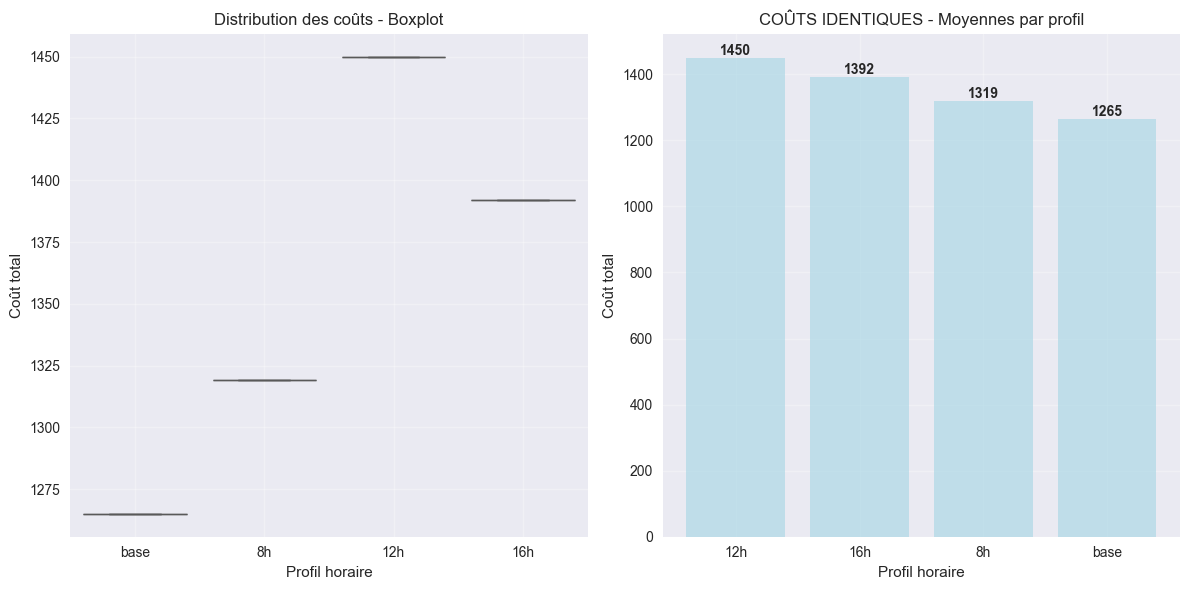

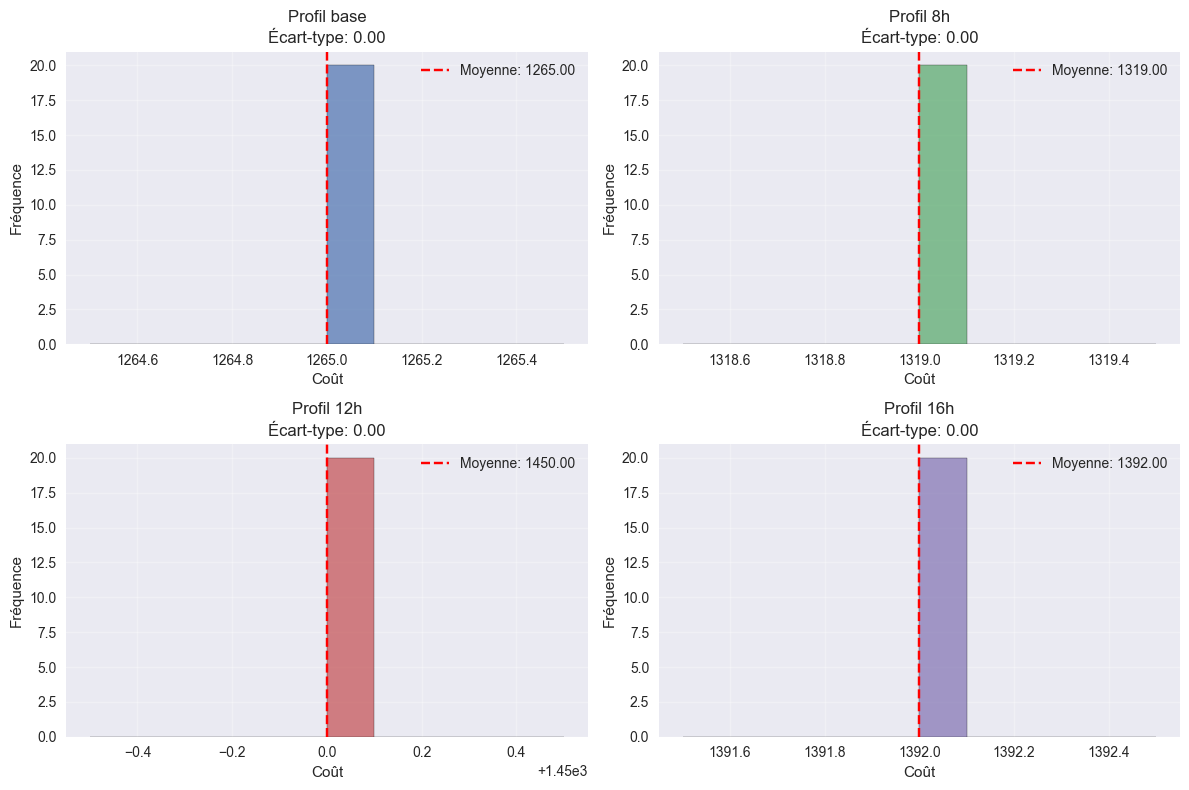


📈 TABLEAU RÉCAPITULATIF
         cost                           gap_%      time_s      
        count    mean  std   min   max   mean  std   mean   std
traffic                                                        
12h        20  1450.0  0.0  1450  1450  14.62  0.0   0.30  0.01
16h        20  1392.0  0.0  1392  1392  10.04  0.0   0.29  0.02
8h         20  1319.0  0.0  1319  1319   4.27  0.0   0.30  0.01
base       20  1265.0  0.0  1265  1265   0.00  0.0   0.29  0.01


C:\Users\gdani\AppData\Local\Temp\ipykernel_20244\2263295433.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x="traffic", y="gap_%", palette="viridis")


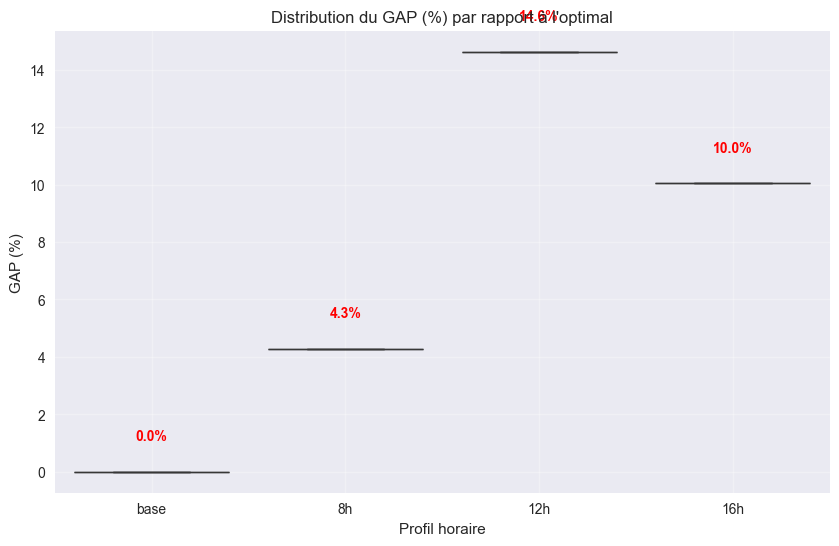


✅ DIAGNOSTIC TERMINÉ!
🔍 Si écart-type = 0, vérifiez votre algorithme tabou_multi_start()
   - Y a-t-il de l'aléatoire dans l'initialisation?
   - Le nombre d'itérations est-il suffisant?
   - Les mouvements tabous sont-ils variés?


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

# === Chargement des matrices ===
matrices = {
    "base": lire_matrice_csv(csv_path),
    "8h": lire_matrice_csv(f"matrice/{nameFile.replace('.csv','')}_8h.csv"),
    "12h": lire_matrice_csv(f"matrice/{nameFile.replace('.csv','')}_12h.csv"),
    "16h": lire_matrice_csv(f"matrice/{nameFile.replace('.csv','')}_16h.csv")
}

# === Lancement des expériences ===
def run_multiple_experiments(matrix, n_runs=20):
    results = []
    for i in range(n_runs):
        start = time.time()
        best_cost, best_iter, best_solution = tabou_multi_start(matrix, nb_lancements=1)
        duration = time.time() - start
        results.append({
            "run": i + 1,
            "cost": best_cost,
            "iteration": best_iter,
            "time_s": duration
        })
        print(f" Run {i+1}/{n_runs} terminé — Coût = {best_cost} | Temps = {duration:.2f}s")
    return pd.DataFrame(results)

# === Exécution pour chaque profil ===
df_list = []
for profile, mat in matrices.items():
    print(f"\n=== Lancement des runs pour {profile} ===")
    df_profile = run_multiple_experiments(mat, n_runs=20)
    df_profile["traffic"] = profile
    df_list.append(df_profile)

# Fusion des résultats
df_results = pd.concat(df_list, ignore_index=True)
df_results.to_csv("resultats_tabou_bouchons.csv", index=False)
print("\nRésultats sauvegardés dans 'resultats_tabou_bouchons.csv'")

# === Analyse statistique ===
def analyse_resultats(df):
    print("\n === Statistiques globales ===")
    print(df.describe()[["cost", "time_s"]])

    cout_moyen = df["cost"].mean()
    ecart_type = df["cost"].std()
    cout_min = df["cost"].min()
    cout_max = df["cost"].max()
    n = len(df)

    # Intervalle de confiance 95%
    if n > 1:
        ic95_low = cout_moyen - 1.96 * ecart_type / np.sqrt(n)
        ic95_high = cout_moyen + 1.96 * ecart_type / np.sqrt(n)
    else:
        ic95_low, ic95_high = None, None

    print(f"\nCoût moyen : {cout_moyen:.2f}")
    print(f"Écart-type : {ecart_type:.2f}")
    print(f"Meilleur coût : {cout_min:.2f}")
    print(f"Pire coût : {cout_max:.2f}")
    if ic95_low is not None:
        print(f"IC95% : [{ic95_low:.2f}, {ic95_high:.2f}]")

# Affichage par profil
for profile in df_results["traffic"].unique():  
    print(f"\n=== Statistiques pour le profil {profile} ===")
    analyse_resultats(df_results[df_results["traffic"] == profile])

# === Visualisation des coûts ===
plt.figure(figsize=(8,5))
sns.boxplot(data=df_results, x="traffic", y="cost")
plt.title("Comparaison du coût selon le profil de trafic")
plt.ylabel("Coût total")
plt.xlabel("Profil horaire")
plt.grid(alpha=0.3)
plt.show()

# Histogramme des temps
plt.figure(figsize=(6,5))
plt.hist(df_results["time_s"], bins=8, color="skyblue", edgecolor="black")
plt.title("Distribution des temps d'exécution")
plt.xlabel("Temps (s)")
plt.ylabel("Fréquence")
plt.grid(alpha=0.3)
plt.show()


opt_cost = df_results["cost"].min()
df_results["gap_%"] = 100 * (df_results["cost"] - opt_cost) / opt_cost

print("\n=== GAP (%) par rapport à la solution optimale ===")
print(df_results.groupby("traffic")[["cost", "gap_%"]].mean())

# Boxplot du GAP
plt.figure(figsize=(8,5))
sns.boxplot(data=df_results, x="traffic", y="gap_%")
plt.title("Distribution du GAP (%) par rapport à la meilleure solution")
plt.ylabel("GAP (%)")
plt.xlabel("Profil horaire")
plt.grid(alpha=0.3)
plt.show()
